In [1]:
# importing packages and modules
import numpy as np
import jax.numpy as jnp
#import autograd.numpy as jnp
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
from jax import value_and_grad
#from autograd import value_and_grad

colorsStates = ['tab:orange','tab:blue', 'tab:green','tab:red'] 
sns.set_context("talk")

In [2]:
# setting hyperparameters
S = 100 # sessions
T = 10000 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

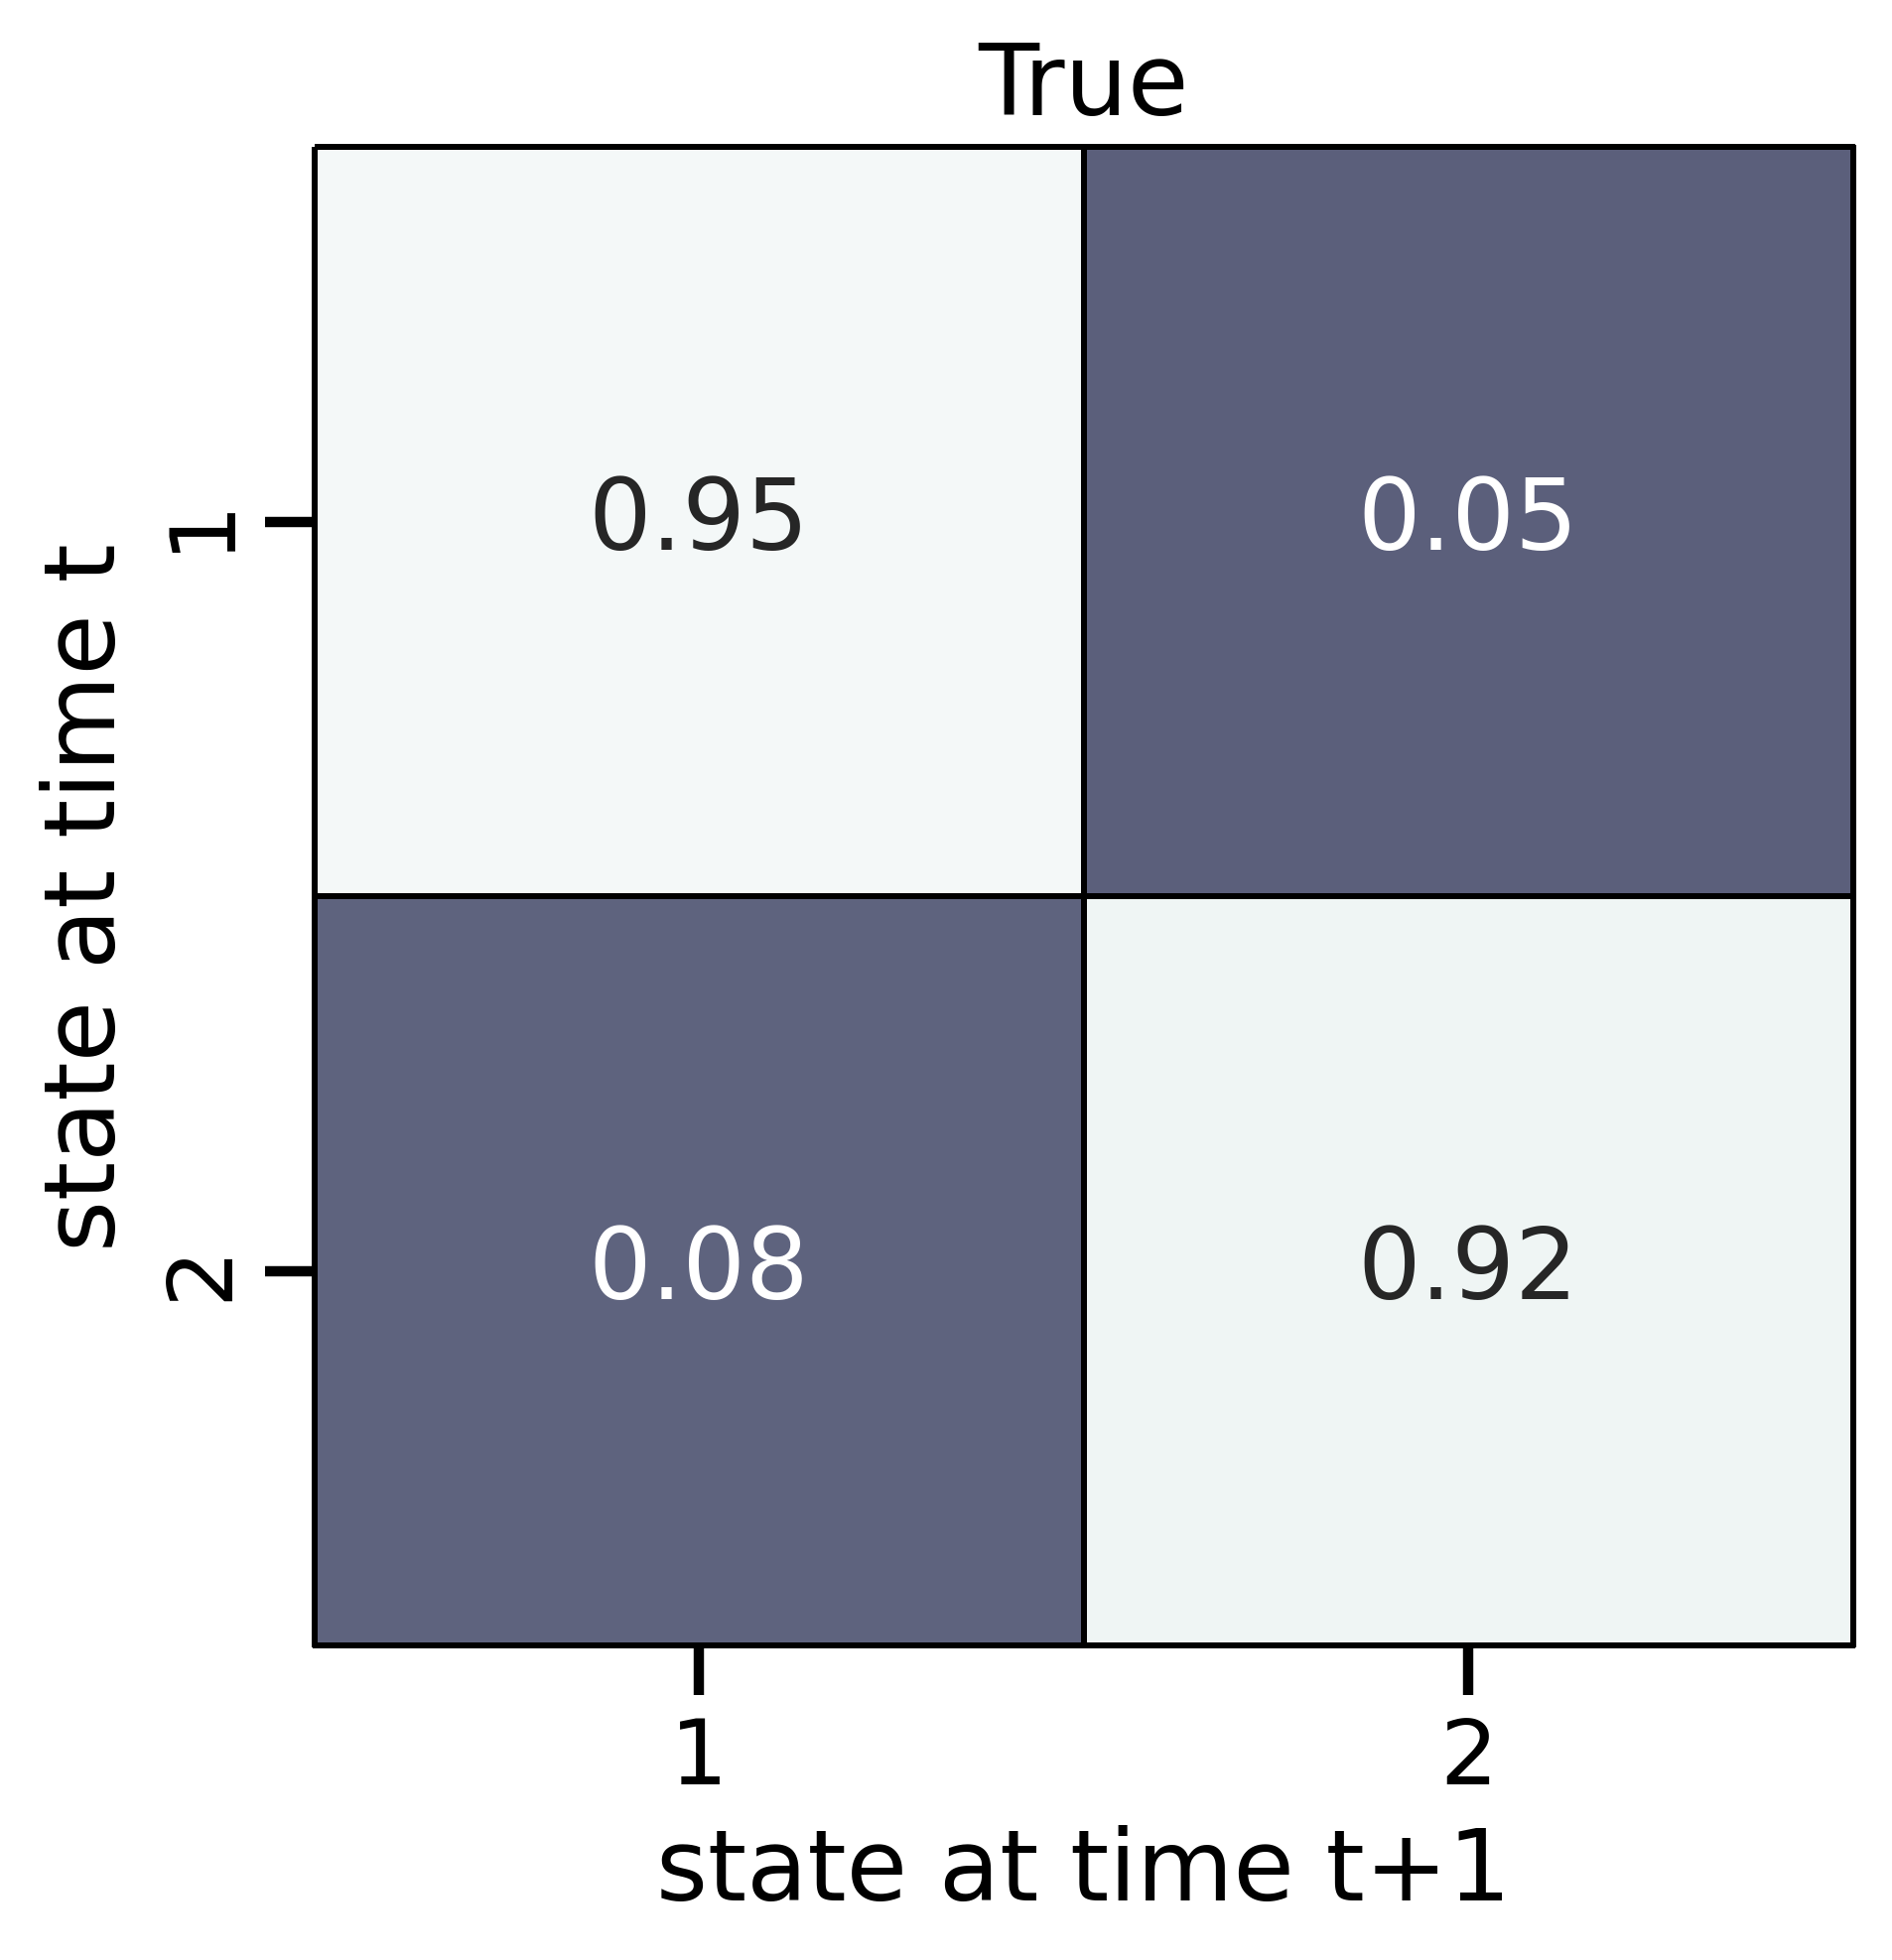

In [3]:
# True Transition Matrix
# trueP = jnp.zeros((2,2))
# trueP = trueP.at[0,0].set(0.97)
# trueP = trueP.at[0,1].set(0.03)
# trueP = trueP.at[1,0].set(.05)
# trueP = trueP.at[1,1].set(.95)
trueP = np.zeros((2,2))
trueP[0,0]=0.95
trueP[0,1]=0.05
trueP[1,0]=.08
trueP[1,1]=.92
plot_transition_matrix(trueP, title='True')

# Varying weights and transition matrix

0.85
0.81
0.92
0.79
0.89
0.88


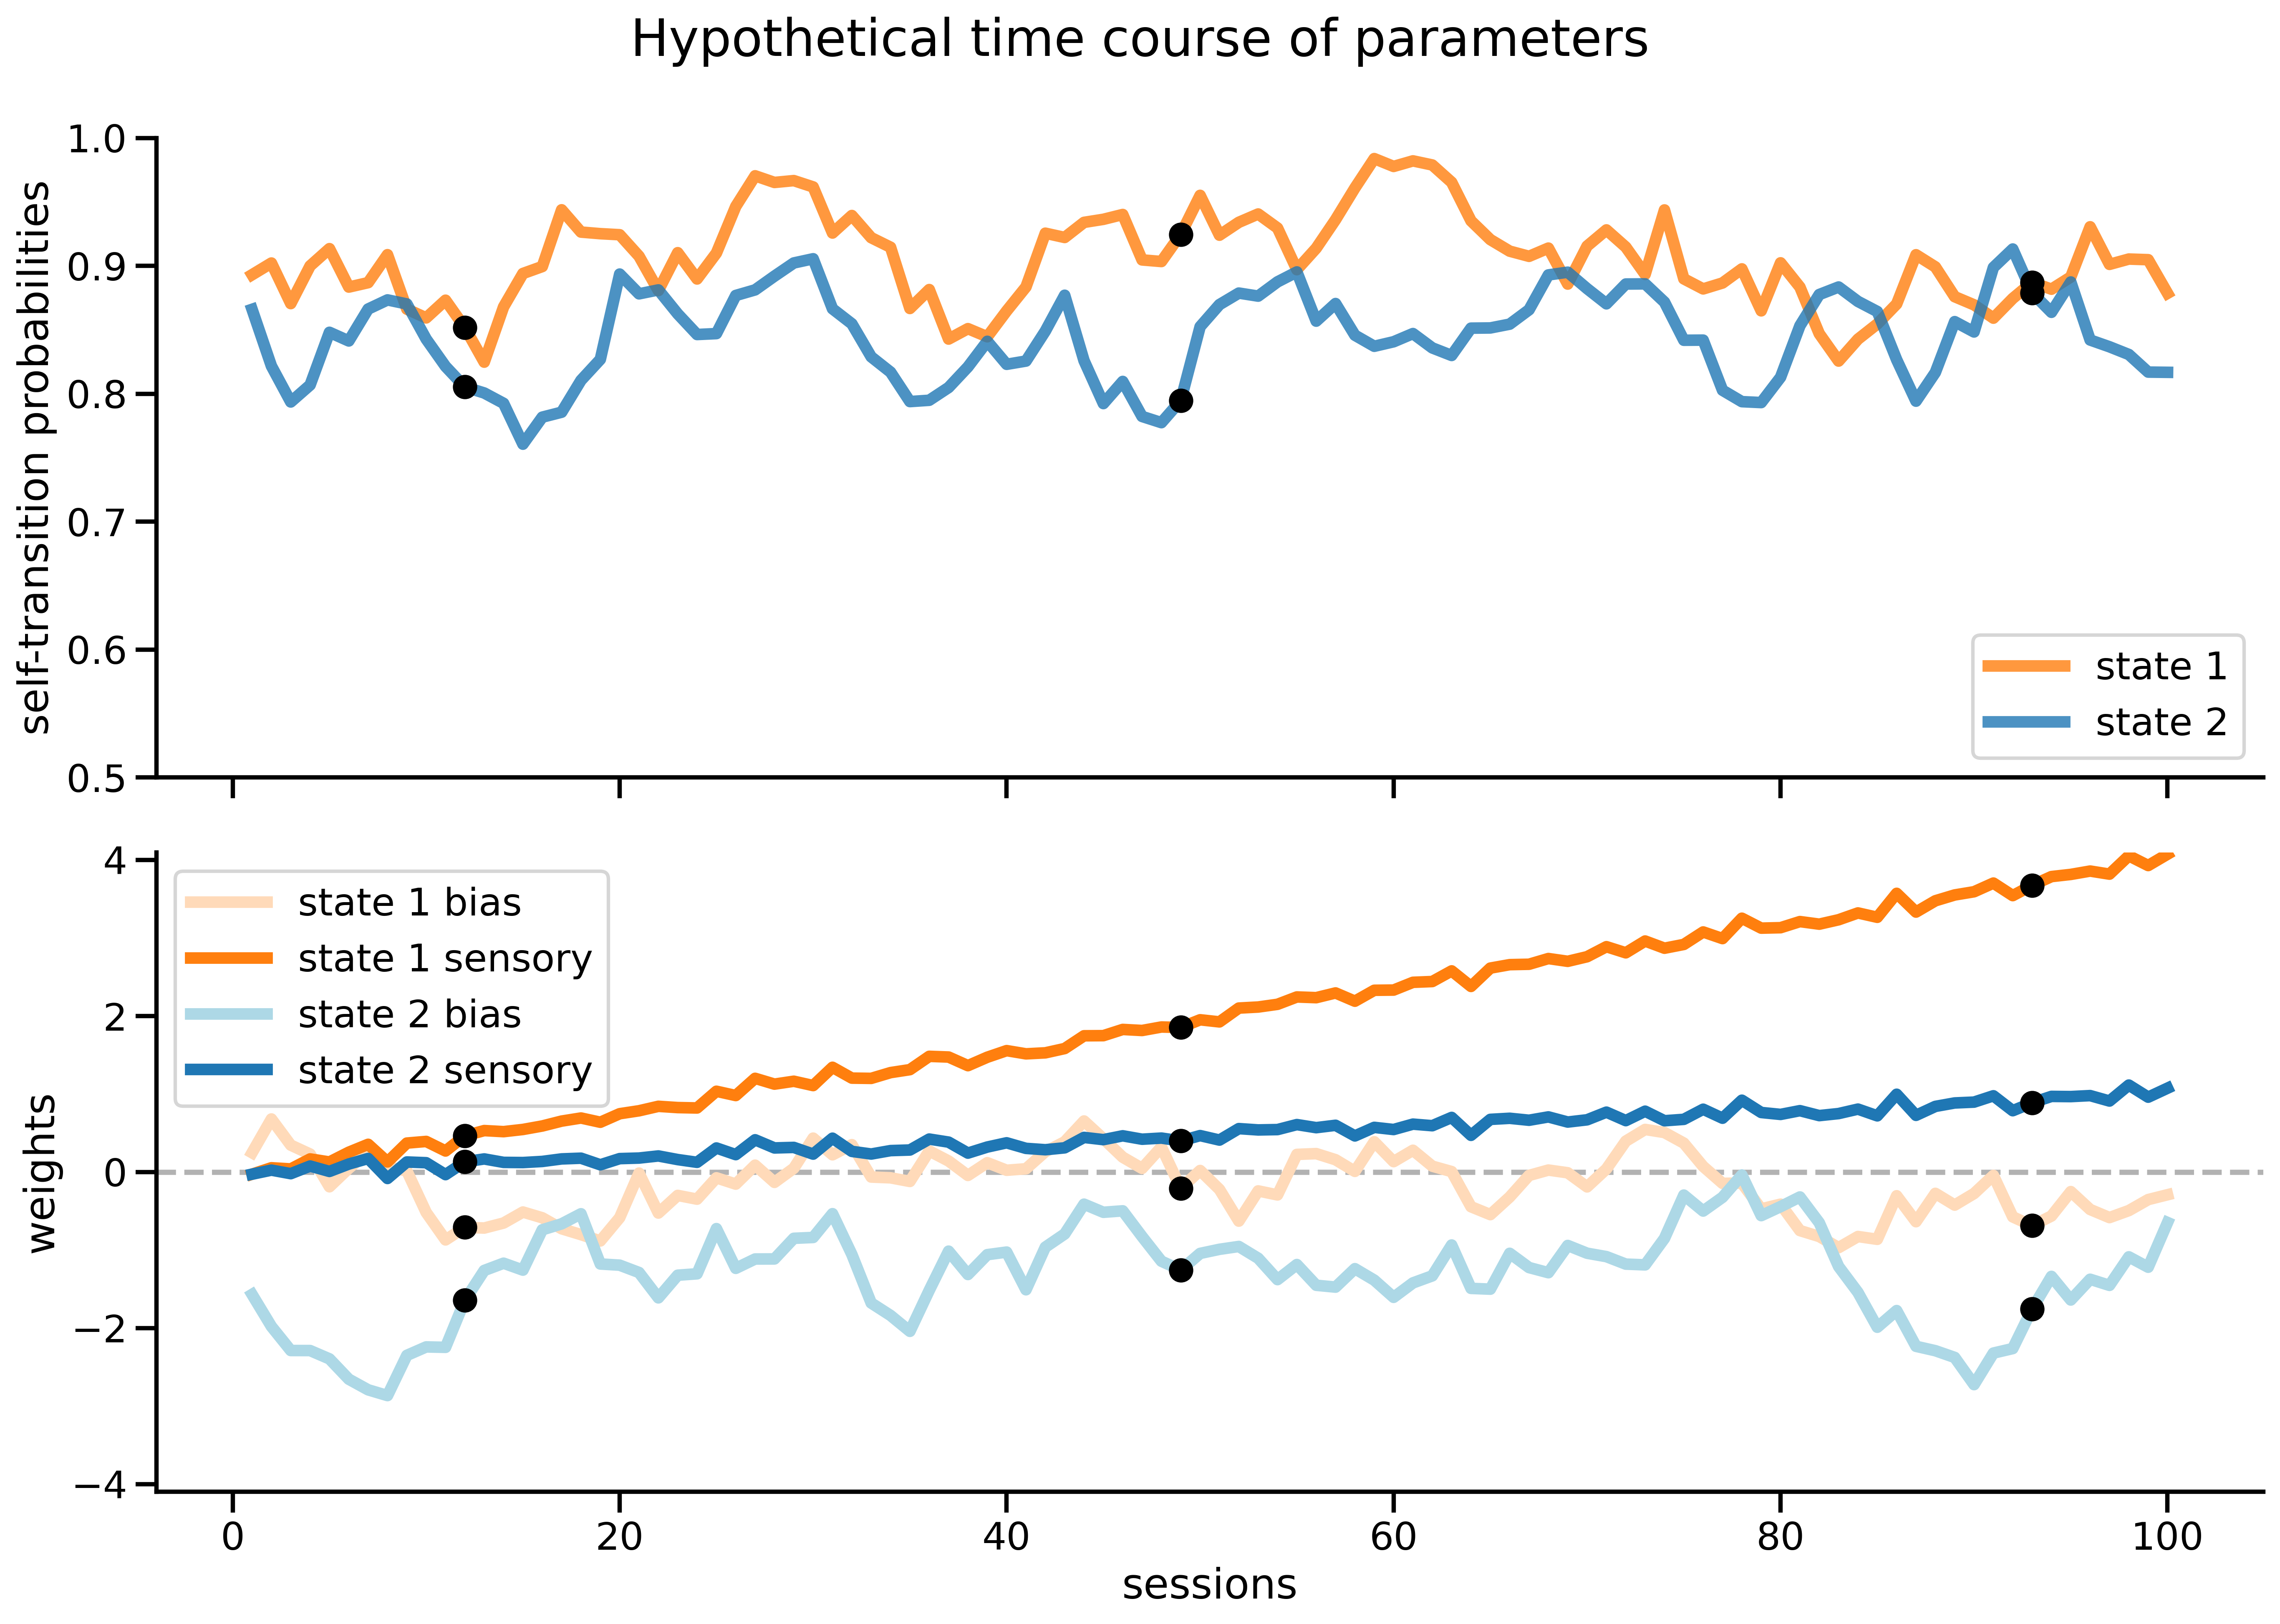

In [37]:
# # True Weights and Session Start Indices
# ourW = np.zeros((S,K,D))
# ourW[:,0,1] = np.linspace(0,4,S) # state 1 sensory (increasing)
# Twindow = 10
# gaussians = np.random.normal(0,1.5,S+Twindow)
# for t in range(Twindow):
#     ourW[:,0,0] += gaussians[t:(-Twindow+t)]
# ourW[:,0,0] = ourW[:,0,0] / Twindow # state 1 bias
# ourW[:,1,1] = np.linspace(0,1,S) # state 2 sensory 
# Twindow = 10
# gaussians = np.random.normal(-1,2,S+Twindow)
# for t in range(Twindow):
#     ourW[:,1,0] += gaussians[t:(-Twindow+t)]
# ourW[:,1,0] = ourW[:,1,0] / Twindow # state 2 bias
# np.save('../data_M1/Figure1_weights.npy', ourW)

# trueP = np.zeros((2,2))
# trueP[0,0]=0.92
# trueP[0,1]=0.08
# trueP[1,0]=.13
# trueP[1,1]=.87

# ourP = np.zeros((S+5,K,K))
# # # change weight format to have session*trials points
# trueP[0,0]=0.9
# trueP[0,1]=0.1
# trueP[1,0]=.15
# trueP[1,1]=.85
# for sess in range(0,S+5):
#     noise = np.random.normal(0,0.08,1)
#     ourP[sess,0,0] = trueP[0,0] + noise
#     noise = np.random.normal(0,0.08,1)
#     ourP[sess,1,1] = trueP[1,1] + noise
# for sess in range(0,S):
#     ourP[sess,0,0] = ourP[sess:sess+5,0,0].mean()
#     ourP[sess,1,1] = ourP[sess:sess+5,1,1].mean()
# ourP[:,0,1] = 1 - ourP[:,0,0]
# ourP[:,1,0] = 1 - ourP[:,1,1]
# np.save('../data_M1/Figure1_transition_matrix.npy', ourP)

ourP = np.load('../data_M1/Figure1_transition_matrix.npy')
ourW = np.load('../data_M1/Figure1_weights.npy')
trueW = np.zeros((N,K,D,C))
# # change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    noise = np.random.normal(0,0.07,1)
    for t in range(0,T):
        trueW[sess*T+t,:,:,1] = ourW[sess,:,:] + noise
sessInd.append(N)

fig, axes = plt.subplots(2, figsize = (14,10), dpi=400, sharex=True)

axes[0].set_ylim(0.5,1)
axes[0].set_ylabel('self-transition probabilities')
axes[0].plot(range(1,S+1),ourP[:S,0,0],color=colorsStates[0],linewidth=5,label=f'state 1', alpha=0.8, linestyle='-')
axes[0].plot(range(1,S+1),ourP[:S,1,1],color=colorsStates[1],linewidth=5,label=f'state 2', alpha=0.8, linestyle='-')
for earlySess in [12,49,93]:
    axes[0].scatter(earlySess,ourP[earlySess-1,0,0],color='black',alpha=1,zorder=2)
    axes[0].scatter(earlySess,ourP[earlySess-1,1,1],color='black',alpha=1,zorder=2)
    print(np.round(ourP[earlySess-1,0,0],2))
    print(np.round(ourP[earlySess-1,1,1],2))
axes[0].legend(loc='lower right')

axes[1].set_ylim(-4.1,4.1)
axes[1].set_ylabel('weights')
axes[1].set_xlabel('sessions')
axes[1].axhline(0, alpha=0.3, color='black',linestyle='--')
axes[1].plot(range(1,sess+2),trueW[sessInd[:-1],0,0,1],color='peachpuff',linewidth=5,label=f'state 1 bias', alpha=1, linestyle='-')
axes[1].plot(range(1,sess+2),trueW[sessInd[:-1],0,1,1],color=colorsStates[0],linewidth=5,label=f'state 1 sensory', alpha=1, linestyle='-')
axes[1].plot(range(1,sess+2),trueW[sessInd[:-1],1,0,1],color='lightblue',linewidth=5,label=f'state 2 bias', alpha=1, linestyle='-')
axes[1].plot(range(1,sess+2),trueW[sessInd[:-1],1,1,1],color=colorsStates[1],linewidth=5,label=f'state 2 sensory', alpha=1, linestyle='-')
for earlySess in [12,49,93]:
    axes[1].scatter(earlySess,trueW[sessInd[earlySess-1],0,0,1],color='black',alpha=1,zorder=2)
    axes[1].scatter(earlySess,trueW[sessInd[earlySess-1],0,1,1],color='black',alpha=1,zorder=2)
    axes[1].scatter(earlySess,trueW[sessInd[earlySess-1],1,0,1],color='black',alpha=1,zorder=2)
    axes[1].scatter(earlySess,trueW[sessInd[earlySess-1],1,1,1],color='black',alpha=1,zorder=2)
axes[1].legend(loc='upper left')
fig.suptitle('Hypothetical time course of parameters', size=22)
fig.tight_layout()
axes[0].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
plt.savefig(f'../figures_M1/Figure1_true_parameters.png', bbox_inches='tight', dpi=400)

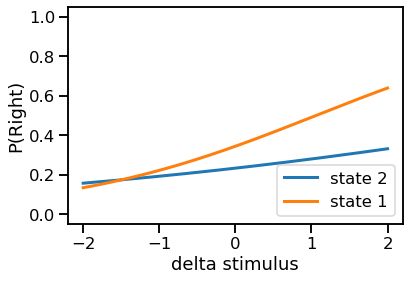

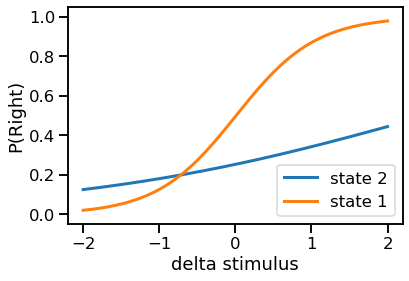

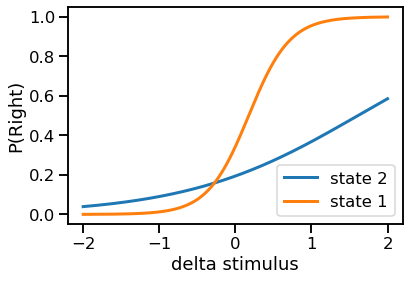

In [32]:
for session in [12,49,93]:
    fig, axes = plt.subplots()
    plotting_psychometric(w=trueW, sessInd=sessInd, session=session, axes=axes, colorsStates=colorsStates)
    axes.set_title('')
